In [1]:
import numpy as np
import os
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
sns.set_style("whitegrid")
from sklearn.metrics import accuracy_score

import torch

In [2]:
# Hilfsfunktion um die vorhergesagten Wahrscheinlichkeiten in die Klassen umzuwandeln
def convert_prob_into_class(probs):
    probs_ = np.copy(probs)
    probs_[probs_ > 0.5] = 1
    probs_[probs_ <= 0.5] = 0
    return probs_

In [3]:
# Hilfsfunktion um die Daten zu visualisieren
def make_plot(X, y, plot_name, file_name=None, XX=None, YY=None, preds=None, dark=False):
    if (dark):
        plt.style.use('dark_background')
    else:
        sns.set_style("whitegrid")
    plt.figure(figsize=(16,12))
    axes = plt.gca()
    axes.set(xlabel="$X_1$", ylabel="$X_2$")
    plt.title(plot_name, fontsize=30)
    plt.subplots_adjust(left=0.20)
    plt.subplots_adjust(right=0.80)
    if(XX is not None and YY is not None and preds is not None):
        plt.contourf(XX, YY, preds.reshape(XX.shape), 25, alpha = 1, cmap=cm.Spectral)
        plt.contour(XX, YY, preds.reshape(XX.shape), levels=[.5], cmap="Greys", vmin=0, vmax=.6)
    plt.scatter(X[:, 0], X[:, 1], c=y.ravel(), s=40, cmap=plt.cm.Spectral, edgecolors='black')
    if(file_name):
        plt.savefig(file_name)
        plt.close()

In [4]:
# Größe des Datensatzes
N_SAMPLES = 1000
# Größe des Testsets
TEST_SIZE = 0.1

## Hier werden die Daten von dem alten Modell erstellt. In der Wirklichkeit sehen wir das nicht.

In [5]:
# Generierung des Datansatzes und split in test und train set
X, y_true = make_moons(n_samples = N_SAMPLES, noise=0.2, random_state=100)

In [6]:
# Generierung der Daten durch ein anderes Model
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_default_device(device)
model = torch.nn.Sequential(
            torch.nn.Linear(2, 25),
            torch.nn.ReLU(),
            torch.nn.Linear(25, 50),
            torch.nn.ReLU(),
            torch.nn.Linear(50, 25),
            torch.nn.ReLU(),
            torch.nn.Linear(25, 1),
            torch.nn.Sigmoid()
)
model.load_state_dict(torch.load('./old_model'))
xx = torch.from_numpy(X).to(device,torch.float32)
y_pred = model(xx).cpu().detach().numpy().squeeze()
y = convert_prob_into_class(y_pred)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=42)

## Hier trainieren wir ein neues Modell auf die geklauten Daten

In [8]:
# Check ob eine GPU da ist
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_default_device(device)

# Festlegen der Architektur
model_steal = torch.nn.Sequential(
            torch.nn.Linear(2, 50),
            torch.nn.ReLU(),
            torch.nn.Linear(50, 1),
            torch.nn.Sigmoid()
)
# Festlegen der Lossfunktion
loss_fn = torch.nn.BCELoss()

# Alles rüberschieben, sodass pytorch alles übernimmt
# Pytorch will Tensoren haben
xx = torch.from_numpy(X_train).to(device,torch.float32)
yy = torch.from_numpy(y_train).to(device,torch.float32)
yy = yy.unsqueeze(-1)

# Festlegen der Lernrate 
learning_rate = 1e-4
# Festlegen des Optimierungsalgorithmus
optimizer = torch.optim.RMSprop(model_steal.parameters(), lr=learning_rate)
# Schleife über eine Anzahl von vorher festgelegten Epochen, um zu lernen
for t in range(10000):
    # Vorwärtsdurchlauf
    y_pred = model_steal(xx)

    # Lossfunktion ausrechnen und anzeigen
    loss = loss_fn(y_pred, yy)
    if t % 100 == 99:
        print(t, loss.item())

    # Pytorch buffert den Gradienten aus allen vorigen Berechnungen
    # Um das los zu werden und nur den aktuellen zu haben
    # Nullen wir einmal den Gradienten
    optimizer.zero_grad()

    # Rückwärtsdurchlauf
    loss.backward()

    # Update der Parameter
    optimizer.step()

99 0.6876600384712219
199 0.6547042727470398
299 0.625734806060791
399 0.598175048828125
499 0.5712935924530029
599 0.5450762510299683
699 0.5196303129196167
799 0.4951513707637787
899 0.4718952178955078
999 0.45003315806388855
1099 0.42963454127311707
1199 0.41065964102745056
1299 0.3931148052215576
1399 0.37696540355682373
1499 0.362179696559906
1599 0.3487464487552643
1699 0.3365445137023926
1799 0.32545042037963867
1899 0.3152875304222107
1999 0.3059003949165344
2099 0.2972166836261749
2199 0.2891993820667267
2299 0.28186923265457153
2399 0.2751893401145935
2499 0.26904618740081787
2599 0.2633637487888336
2699 0.2581522762775421
2799 0.25336453318595886
2899 0.24894170463085175
2999 0.24483315646648407
3099 0.24104182422161102
3199 0.2374950796365738
3299 0.23421292006969452
3399 0.2311757206916809
3499 0.22825245559215546
3599 0.2253541499376297
3699 0.2225300669670105
3799 0.2197479009628296
3899 0.21695473790168762
3999 0.21419069170951843
4099 0.21144281327724457
4199 0.2086778

In [9]:
# Hilfsvariablen für die Visualisierung
GRID_X_START = -1.5
GRID_X_END = 2.5
GRID_Y_START = -1.0
GRID_Y_END = 2

# Erstellen eines Gitter für das Bild
grid = np.mgrid[GRID_X_START:GRID_X_END:100j,GRID_X_START:GRID_Y_END:100j]
grid_2d = grid.reshape(2, -1).T
XX, YY = grid

In [10]:
# Testset zu pytorch schrieben
xx_test = torch.from_numpy(X_test).to(device,torch.float32)
# Vorwärtsdurchlauf auf dem Testset
y_hat = model_steal(xx_test).cpu().detach().numpy()
# Umwandeln in Klassen
y_pred = convert_prob_into_class(y_hat)
acc_test = (y_test.reshape(int(N_SAMPLES*TEST_SIZE),1) == y_pred).all(axis=1).mean()
print("Test set accuracy: {:.2f}".format(acc_test))

Test set accuracy: 0.97


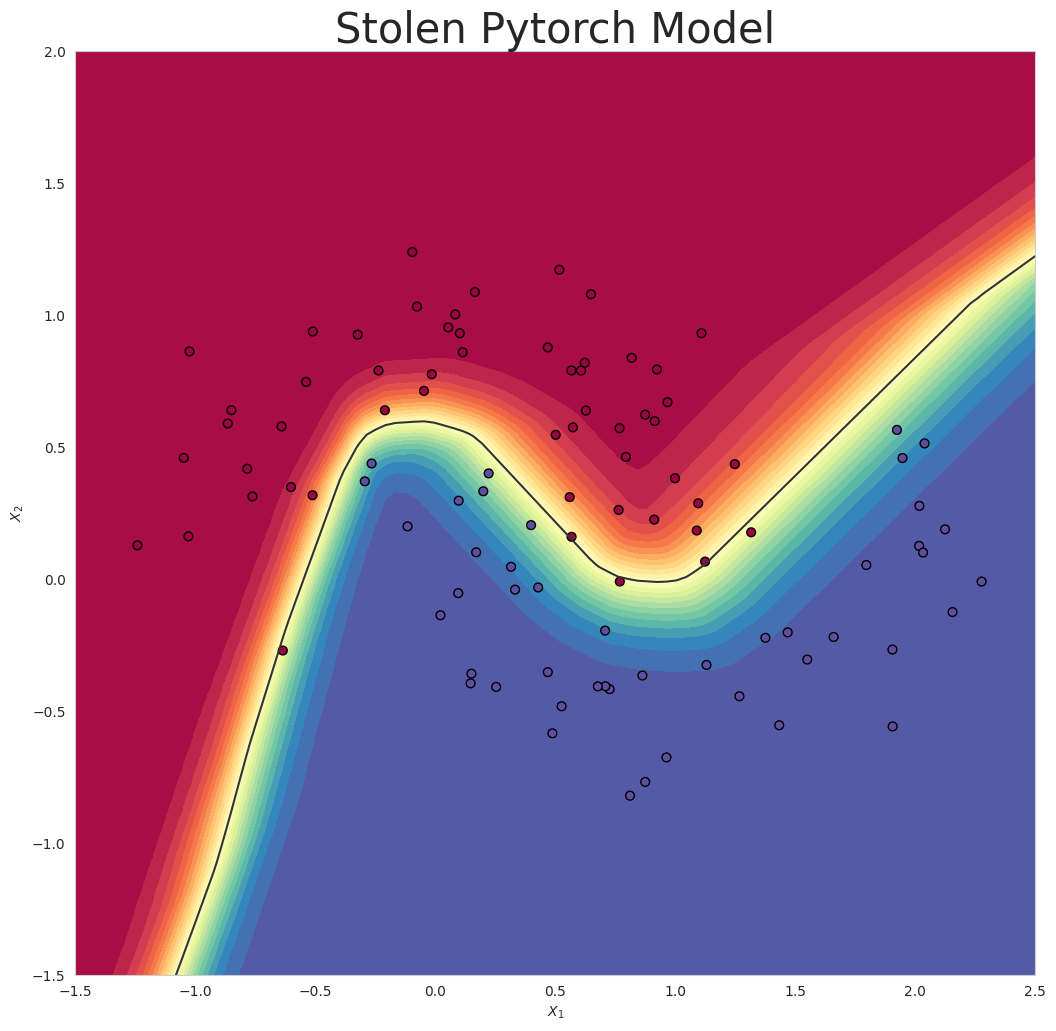

In [11]:
# Visualisierung auf dem Gitter
xx = torch.from_numpy(grid_2d).to(device,torch.float32)
y_plot = y_hat = model_steal(xx).cpu().detach().numpy()
make_plot(X_test, y_test, "Stolen Pytorch Model", file_name=None, XX=XX, YY=YY, preds=y_plot)